## Hyperparameter Optimization

Data analytics can be viewed as a series of optimization tasks. For instance, supervised learning seeks to minimize predictive errors as measured by a variety of metrics, e.g., mean square error, mean absolute error, mis-classification error, area under the (ROC) curve, etc.

Since the methods of analytics themselves have parameters, when apply these methods, we also need to find optimal settings for the hyperparameters. There are two convient approaches to doing this available in sklearn: grid search and random search.

In [3]:

# Data processing and functions
import pandas as pd
import numpy as np
import scipy as sp

# Analytics and modeling
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler


# Graphing and visualizing
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm
from pylab import savefig


# Setting graphing preferences
sns.set(style="darkgrid", color_codes=True)

# Printing
import locale

# Show plots locally
locale.setlocale( locale.LC_ALL, '' )

%matplotlib inline

## Exercise 

Load and clean  the mammogram data: MammogramData.csv

In [4]:
# Load the mammogram data

path = "/Users/Pan/Google Drive/Data Science/DS6001/"
file = "MammogramData.csv"

mammogram_df = pd.read_csv(path+file)

In [5]:
mammogram_df.isnull().sum()

BiRads       2
Age          5
Shape       31
Margin      48
Density     76
Severity     0
dtype: int64

In [6]:
from sklearn.base import TransformerMixin

class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.
        
        Columns of dtype floating point are imputed with the mean.

        Columns of other types are imputed with median of the column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') 
                               else X[c].mean() if X[c].dtype == np.dtype('f')
                                else X[c].median() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)



In [7]:
mammogram_clean_df = DataFrameImputer().fit_transform(mammogram_df)
mammogram_clean_df.isnull().sum()

BiRads      0
Age         0
Shape       0
Margin      0
Density     0
Severity    0
dtype: int64

In [8]:
# Creating predictor Dataframe and
# Dummy variable assignment

# Dummy variables

mammogram_pred_df = pd.get_dummies(mammogram_clean_df, columns = ['Density', 'Margin'], drop_first = True)



# Separating predictors and response

mammogram_pred_df = mammogram_clean_df.drop('Severity', axis = 1)




In [9]:
# change variables to categorical 
    
mammogram_clean_df['Shape'] = mammogram_clean_df['Shape'].astype('category').unique()
mammogram_clean_df['Margin'] = mammogram_clean_df['Shape'].astype('category').unique()
mammogram_clean_df.dtypes

BiRads       float64
Age          float64
Shape       category
Margin      category
Density      float64
Severity       int64
dtype: object

## Random Forest

In [10]:
# Random Forest Classifier
# Change number of trees

from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(mammogram_pred_df, 
                                                    mammogram_clean_df['Severity'], random_state=42)


rf = RandomForestClassifier(n_estimators = 400, max_features = 0.15)
#n_estimators = number of trees. max_features = % of features. since if =1, all trees will be similar
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)


#Performance on the test set

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))


cnf_rf = confusion_matrix(y_test,y_pred)
print(cnf_rf)

Accuracy: 81.74%
[[108  20]
 [ 24  89]]


In [11]:
# Get the predicted probabilities 
# and the FPR and TPR

y_pred_rf400 = rf.predict_proba(X_test)
y_pred_rf400 = y_pred_rf400[:,1]
RF400_auc = roc_auc_score(y_test, y_pred)
print("AUC: %.2f%%" % (RF400_auc * 100.0))
RF400_fpr, RF400_tpr, RF400_thresholds = roc_curve(y_test, y_pred_rf400)

AUC: 81.57%


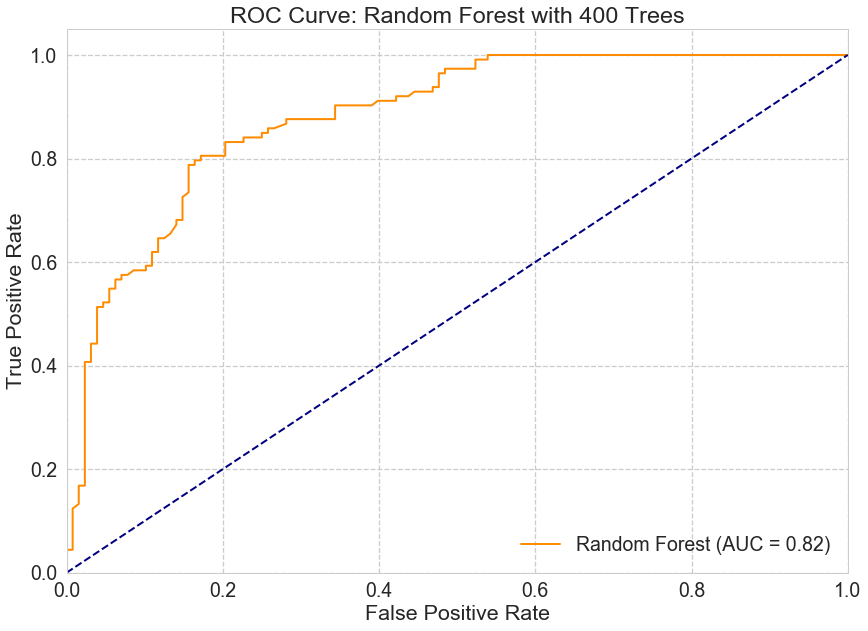

In [12]:
# ROC Plot


sns.set('talk', 'whitegrid', 'dark', font_scale=1.5, font='Arial',
        rc={"lines.linewidth": 2, 'grid.linestyle': '--'})


lw = 2
plt.figure(figsize = (14,10))
plt.plot(RF400_fpr, RF400_tpr, color='darkorange',
         lw=lw, label='Random Forest (AUC = %0.2f)' % RF400_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Random Forest with 400 Trees')
plt.legend(loc="lower right")
plt.show()
#plt.savefig('roc_auc.png')
plt.close()

## Grid Search

or you can try random search. give a range.

In [13]:
from sklearn.model_selection import GridSearchCV

grid_hp = [{'n_estimators': [200, 500, 1000], 'max_features': [.15, .25, .45]}]

rf = RandomForestClassifier()

rf.fit(X_train, y_train)

grid_search = GridSearchCV(rf, grid_hp, cv = 5)

grid_search.fit(X_train, y_train)


#Selected parameter values

grid_search.best_params_



{'max_features': 0.25, 'n_estimators': 1000}

In [14]:
# Random Forest Classifier
# with grid search results


rf = RandomForestClassifier(n_estimators = 1000, max_features = 0.15)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)


#Performance on the test set

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))


cnf_rf = confusion_matrix(y_test,y_pred)
print(cnf_rf)

Accuracy: 81.74%
[[108  20]
 [ 24  89]]


In [15]:
# Get the predicted probabilities 
# and the FPR and TPR

y_pred_rf200 = rf.predict_proba(X_test)
y_pred_rf200 = y_pred_rf200[:,1]
RF200_auc = roc_auc_score(y_test, y_pred_rf200)
print("AUC: %.2f%%" % (RF200_auc * 100.0))
RF200_fpr, RF200_tpr, RF200_thresholds = roc_curve(y_test, y_pred_rf200)

AUC: 88.37%


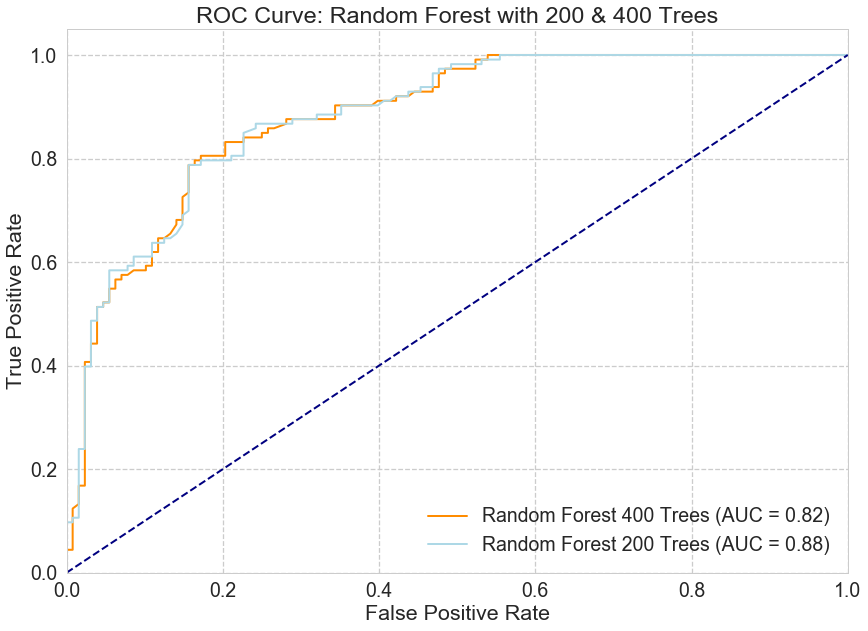

In [16]:
# ROC Plot


sns.set('talk', 'whitegrid', 'dark', font_scale=1.5, font='Arial',
        rc={"lines.linewidth": 2, 'grid.linestyle': '--'})


lw = 2
plt.figure(figsize = (14,10))
plt.plot(RF400_fpr, RF400_tpr, color='darkorange',
         lw=lw, label='Random Forest 400 Trees (AUC = %0.2f)' % RF400_auc)
plt.plot(RF200_fpr, RF200_tpr, color='lightblue',
         lw=lw, label='Random Forest 200 Trees (AUC = %0.2f)' % RF200_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Random Forest with 200 & 400 Trees')
plt.legend(loc="lower right")
plt.show()
#plt.savefig('roc_auc.png')
plt.close()

# Exercise

Use grid search to find optimal parameter settings for Support Vector Machine (SVM)  and Extreme Gradient Boosting (XG Boost) classifiers using the mammogram data as shown above. Choose two kernals to compare for the SVM classiers. Compare the best performing SVM and XG Boost classifiers using an ROC curve. Submit your results in a jupyter notebook.

Extreme Gradient Boosting: ntree & learning rate
SVM: c - complexity cost, cost of misclassifying
     gamma - the larger gamma is, the closer other examples must to be affected

## SVM

In [17]:
from sklearn.svm import SVC
#grid_hp = [{'n_estimators': [200, 500, 1000], 'max_features': [.15, .25, .45]}]
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

svm = SVC()

svm.fit(X_train, y_train)

grid_search = GridSearchCV(svm, tuned_parameters, cv = 5)

grid_search.fit(X_train, y_train)


#Selected parameter values

grid_search.best_params_



{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}

In [18]:
# SVM Classifier
# with grid search results


svm = SVC(kernel='rbf',gamma=0.001,C=1000,probability=True)

svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)


#Performance on the test set

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))


cnf_svm = confusion_matrix(y_test,y_pred)
print(cnf_svm)

Accuracy: 83.82%
[[113  15]
 [ 24  89]]


In [19]:
# Get the predicted probabilities 
# and the FPR and TPR

y_pred_svm200 = svm.predict_proba(X_test)
y_pred_svm200 = y_pred_svm200[:,1]
svm200_auc = roc_auc_score(y_test, y_pred_svm200)
print("AUC: %.2f%%" % (svm200_auc * 100.0))
svm200_fpr, svm200_tpr, svm200_thresholds = roc_curve(y_test, y_pred_svm200)

AUC: 89.23%


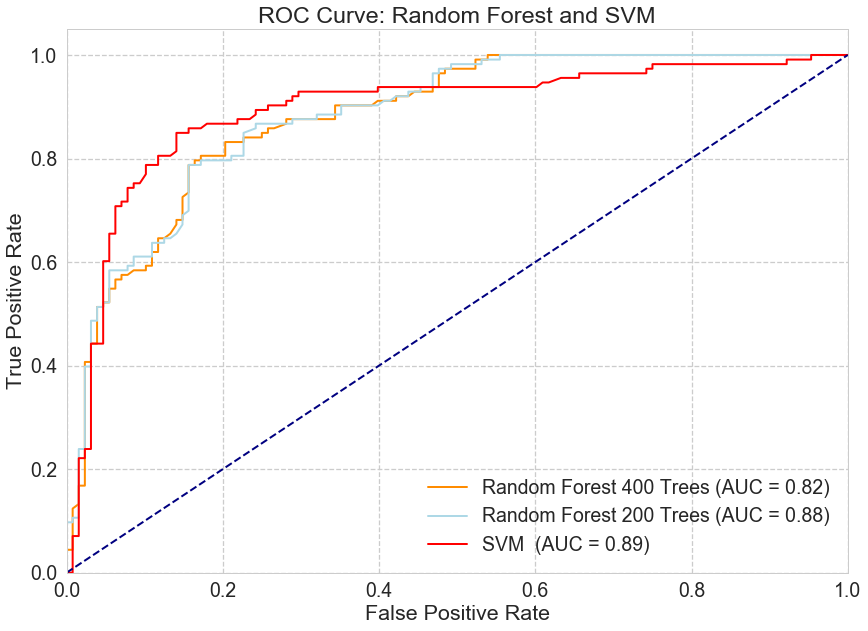

In [20]:
# ROC Plot
sns.set('talk', 'whitegrid', 'dark', font_scale=1.5, font='Arial',
        rc={"lines.linewidth": 2, 'grid.linestyle': '--'})


lw = 2
plt.figure(figsize = (14,10))
plt.plot(RF400_fpr, RF400_tpr, color='darkorange',
         lw=lw, label='Random Forest 400 Trees (AUC = %0.2f)' % RF400_auc)
plt.plot(RF200_fpr, RF200_tpr, color='lightblue',
         lw=lw, label='Random Forest 200 Trees (AUC = %0.2f)' % RF200_auc)

plt.plot(svm200_fpr, svm200_tpr, color='red',
         lw=lw, label='SVM  (AUC = %0.2f)' % svm200_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Random Forest and SVM')
plt.legend(loc="lower right")
plt.show()
#plt.savefig('roc_auc.png')
plt.close()

## XGBoost

In [27]:
!pip install xgboost

    100% |████████████████████████████████| 1.2MB 328kB/s ta 0:00:01
  Running setup.py bdist_wheel for xgboost ... - \ | / - \ | / - \ | / - \ | / - done
  Stored in directory: /Users/Pan/Library/Caches/pip/wheels/5e/c1/d6/522af54e5cc001fad4dd855117f8bf61b11d56443e06672e26
Successfully built xgboost


In [21]:
import xgboost as xgb
tuned_parameters = [{'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['binary:logistic'],
              'learning_rate': [0.001,0.01,0.15], #so called `eta` value
              'max_depth': [5,10,15],
              'min_child_weight': [3,11],
              'silent': [1],
              'subsample': [0.9],
              'colsample_bytree': [0.5],
              'n_estimators': [200,400], #number of trees
              'seed': [1337]}]

xgb_model = xgb.XGBClassifier()

xgb_model.fit(X_train, y_train)

grid_search = GridSearchCV(xgb_model, tuned_parameters, cv = 5)

grid_search.fit(X_train, y_train)


#Selected parameter values

grid_search.best_params_




{'colsample_bytree': 0.5,
 'learning_rate': 0.01,
 'max_depth': 10,
 'min_child_weight': 3,
 'n_estimators': 400,
 'nthread': 4,
 'objective': 'binary:logistic',
 'seed': 1337,
 'silent': 1,
 'subsample': 0.9}

In [26]:
# xgb Classifier
# with grid search results

y_pred = grid_search.predict(X_test)


#Performance on the test set

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))


cnf_myxgboost = confusion_matrix(y_test,y_pred)
print(cnf_myxgboost)

Accuracy: 83.82%
[[110  18]
 [ 21  92]]


In [27]:
# Get the predicted probabilities 
# and the FPR and TPR

y_pred_xgboost = grid_search.predict_proba(X_test)
y_pred_xgboost = y_pred_xgboost[:,1]
xgboost_auc = roc_auc_score(y_test, y_pred_xgboost)
print("AUC: %.2f%%" % (xgboost_auc * 100.0))
xgboost_fpr, xgboost_tpr, xgboost_thresholds = roc_curve(y_test, y_pred_xgboost)

AUC: 91.38%


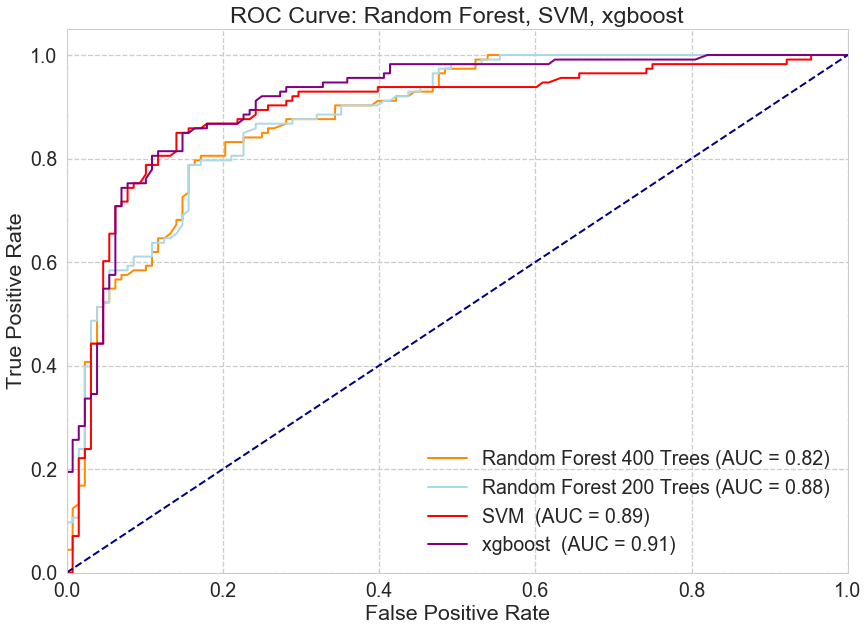

In [28]:
# ROC Plot
sns.set('talk', 'whitegrid', 'dark', font_scale=1.5, font='Arial',
        rc={"lines.linewidth": 2, 'grid.linestyle': '--'})


lw = 2
plt.figure(figsize = (14,10))
plt.plot(RF400_fpr, RF400_tpr, color='darkorange',
         lw=lw, label='Random Forest 400 Trees (AUC = %0.2f)' % RF400_auc)
plt.plot(RF200_fpr, RF200_tpr, color='lightblue',
         lw=lw, label='Random Forest 200 Trees (AUC = %0.2f)' % RF200_auc)
plt.plot(svm200_fpr, svm200_tpr, color='red',
         lw=lw, label='SVM  (AUC = %0.2f)' % svm200_auc)
plt.plot(xgboost_fpr, xgboost_tpr, color='purple',
         lw=lw, label='xgboost  (AUC = %0.2f)' % xgboost_auc)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Random Forest, SVM, xgboost')
plt.legend(loc="lower right")
plt.show()
#plt.savefig('roc_auc.png')
plt.close()